In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
%matplotlib inline

Let's read the data from csv file

In [ ]:
df = pd.read_excel('2019 google BAD sample(1-12).xlsx',sheet_name=0,usecols='A,B,C')
df.columns = ['ID','label','C1']

df.head()

,ID,label,C1
0,201927622,1,test
1,201927623,1,qprm
2,201927624,1,qwert
3,201927625,1,fgfghfg
4,201927626,1,pubg


Let's look into our data

In [ ]:
df.groupby('label').size()

label
0    27621
1      286
dtype: int64

In [ ]:
print(df.isnull().sum())

ID       0
label    0
C1       0
dtype: int64


Now let's create new feature "message length" and plot it to see if it's of any interest

In [ ]:
#응답에 숫자도 있어서 int 형으로 생각함 -> 문자형으로 변환
df['C1'] = df['C1'].apply(str)

In [ ]:
# df['length'] = df['C1'].str.len()
df['length'] = df['C1'].apply(len)


,ID,label,C1,length
0,201927622,1,test,4
1,201927623,1,qprm,4
2,201927624,1,qwert,5
3,201927625,1,fgfghfg,7
4,201927626,1,pubg,4


In [ ]:
#중복 제거
df.drop_duplicates(subset=['C1'],inplace=True) # C1 열에서 중복인 내용이 있다면 중복 제거
df.head()

,ID,label,C1,length
0,201927622,1,test,4
1,201927623,1,qprm,4
2,201927624,1,qwert,5
3,201927625,1,fgfghfg,7
4,201927626,1,pubg,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2055 entries, 0 to 27899
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      2055 non-null   int64 
 1   label   2055 non-null   int64 
 2   C1      2055 non-null   object
 3   length  2055 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 80.3+ KB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6910cfb00>,
      dtype=object)

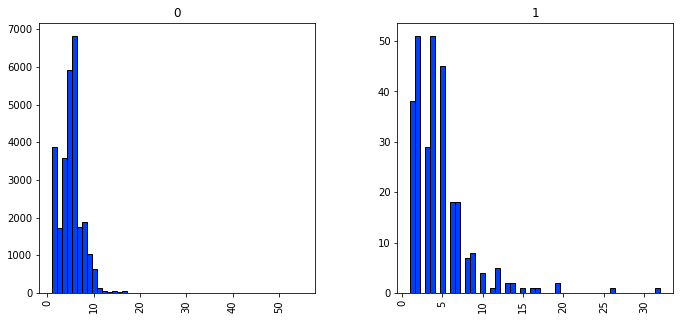

In [ ]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
df.hist(column='length', by='label', bins=50,figsize=(11,5))

Looks like the lengthy is the message, more likely it is a spam. Let's not forget this

### Text processing and vectorizing our meddages

Let's create new data frame. We'll need a copy later on

In [ ]:
text_feat = df['C1'].copy()
text_feat.head()

0       test
1       qprm
2      qwert
3    fgfghfg
4       pubg
Name: C1, dtype: object

Now define our tex precessing function. It will remove any punctuation and stopwords aswell.

In [ ]:
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words()]
    
    return " ".join(text)

In [ ]:
#처음 다운로드할때만
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
text_feat = text_feat.apply(text_process)

In [ ]:
# text_feat = text_feat.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# text_feat=text_feat.dropna(how = 'any') 
# print(text_feat.isnull().values.any()) 


# #한국어니까...영어는 삭제돼서 NULL로 됨.

# Null 값이 존재하는 행 제거.... 제거해야할까?? 
#삭제할경우 -> 불용어 처리를 하다보면 NULL값이 될 수 있는데 불량응답을 나중에 걸러낼 수 있을까? 
#삭제를 안할경우 -> Null 값도 불량응답으로 훈련할텐데 전체베이스가 아닌 오픈문항에서 비포함 케이스도 불량응답으로 처리하지 않을까?

In [ ]:
#벡터화
vectorizer = TfidfVectorizer()

In [ ]:
# #TfidfVectorizer()
# 등장횟수도 많고 문서 분별력 있는 단어들을 스코어링한 것

# #장점
# 선택된 단어는 TF-IDF 스코어를 가지며 어떤 단어가 중요한 단어인지 직관적으로 해석이 가능하며, 
# 전처리(pos-of-tagging)가 잘 수행 되었을때 다른 변수선택/추출보다 견줄만한 성능을 가지고 있다.

# #단점
# 제외된 단어들은 학습에 사용되지 않기 때문에 새로운 단어에 대한 해석이 불가능 
# 순서를 고려하지 않기 때문에 어순에 대한 문법적인 의미를 담고 있지 않는다.

In [ ]:
features = vectorizer.fit_transform(text_feat)

###  Classifiers and predictions

First of all let's split our features to test and train set

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, df['label'], test_size=0.3, random_state=111)

Now let's import bunch of classifiers, initialize them and make a dictionary to itereate through

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

Parametres are based on notebook:
[Spam detection Classifiers hyperparameter tuning][1]


  [1]: https://www.kaggle.com/muzzzdy/d/uciml/sms-spam-collection-dataset/spam-detection-classifiers-hyperparameter-tuning/

In [ ]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

Let's make functions to fit our classifiers and make predictions

In [ ]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)

In [ ]:
def predict_labels(clf, features):
    return (clf.predict(features))

Now iterate through classifiers and save the results

In [ ]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [ ]:
# 오류 : DataFrame.from_items
# df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
score=pd.DataFrame.from_dict(dict(pred_scores),orient='index',columns=['Score'])
score


,Score
SVC,0.909238
KN,0.909238
NB,0.912480
DT,0.392220
LR,0.909238
RF,0.403566
AdaBoost,0.902755
BgC,0.398703
ETC,0.413290


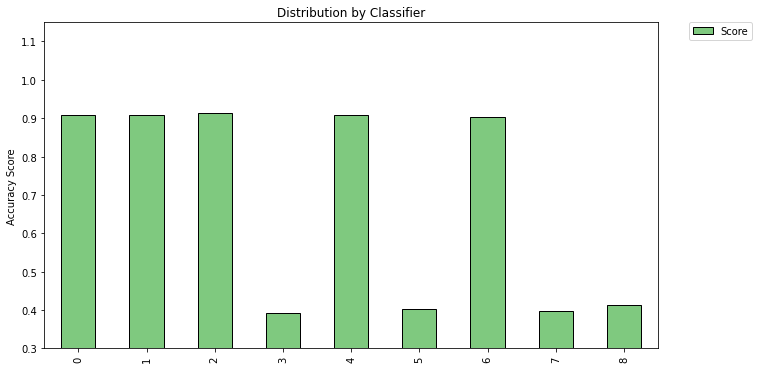

In [ ]:
score.plot(kind='bar', ylim=(0.3,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Looks like ensemble classifiers are not doing as good as expected.

### Stemmer

It is said that stemming short messages does no goot or even harm predictions. Let's try this out.

Define our stemmer function

In [ ]:
# 현재 오픈문항이 단답형이기 때문에 어간추출 생략함

In [ ]:
# def stemmer (text):
#     text = text.split()
#     words = ""
#     for i in text:
#             stemmer = SnowballStemmer("Korean")
#             words += (stemmer.stem(i))+" "
#     return words

In [ ]:
# text_feat = text_feat.apply(stemmer)

In [ ]:
#대신 벡터라이즈를 수정
# CountVectorizer() : 
# 가장 단순한 특징으로, 텍스트에서 단위별 등장횟수를 카운팅하여 수치벡터화
# 특별한 의미를 지니지 않는데 자주 사용되는 단어가 높은 가중을 가질 수 있음

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer2 = CountVectorizer(min_df=1)

In [ ]:
features = vectorizer2.fit_transform(text_feat)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, df['label'], test_size=0.3, random_state=111)

In [ ]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [ ]:
# df2 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score2'])
score2 = pd.DataFrame.from_dict(dict(pred_scores),orient='index', columns=['Score2'])
score = pd.concat([score,score2],axis=1)
score

,Score,Score2
SVC,0.909238,0.909238
KN,0.909238,0.909238
NB,0.912480,0.896272
DT,0.392220,0.401945
LR,0.909238,0.909238
RF,0.403566,0.387358
AdaBoost,0.902755,0.909238
BgC,0.398703,0.376013
ETC,0.413290,0.392220


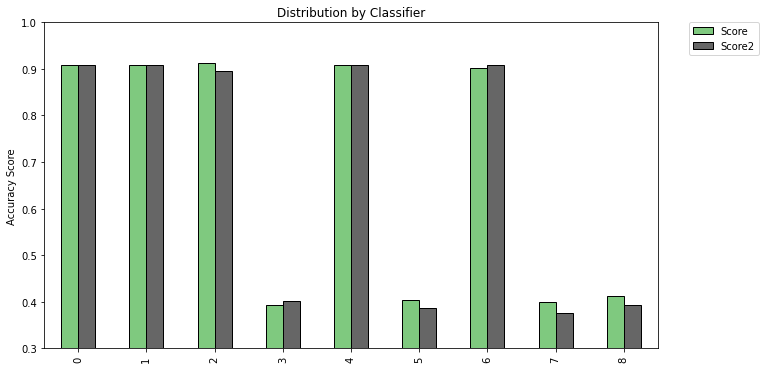

In [ ]:
score.plot(kind='bar', ylim=(0.3,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
#보통 2개를 분류하는 케이스에서는 활성화함수를 'relu'씀.

import keras
from keras.layers import Dense
from keras.models import Sequential

#모델구성
model = Sequential()
model.add(Dense(units = 100 , activation = 'relu' , input_dim = features_train.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               170600    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 177,196
Trainable params: 177,196
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#모델훈련
y_test = np.array(labels_train) #array로 바꿔줘야한다고 함 ...
model.fit(features_train,y_test , epochs = 5)

Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.4841 - accuracy: 0.8832
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3108 - accuracy: 0.8873
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2587 - accuracy: 0.8873
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1832 - accuracy: 0.8873
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1006 - accuracy: 0.9152


In [ ]:
pred = model.predict(features_test)

In [ ]:
print(accuracy_score(labels_test,pred.round()))

0.9173419773095624


Looks like mostly the same . Ensemble classifiers doing a little bit better, NB still got the lead.

### What have we forgotten? Message length!

Let's append our message length feature to the matrix we fit into our classifiers

In [ ]:
# 오류 : as_matrix()
# lf = sms['length'].as_matrix()
lf =df['length'].values
newfeat = np.hstack((features.todense(),lf[:, None]))

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(newfeat, df['label'], test_size=0.3, random_state=111)
features_test

matrix([[0, 0, 0, ..., 0, 0, 5],
        [0, 0, 0, ..., 0, 0, 4],
        [0, 0, 0, ..., 0, 0, 5],
        ...,
        [0, 0, 0, ..., 0, 0, 7],
        [0, 0, 0, ..., 0, 0, 3],
        [0, 0, 0, ..., 0, 0, 7]])

In [ ]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [ ]:
# df3 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score3'])
score3 = pd.DataFrame.from_dict(dict(pred_scores),orient='index', columns=['Score3'])
score = pd.concat([score,score3],axis=1)
score

,Score,Score2,Score3
SVC,0.909238,0.909238,0.917342
KN,0.909238,0.909238,0.909238
NB,0.912480,0.896272,0.902755
DT,0.392220,0.401945,0.865478
LR,0.909238,0.909238,0.909238
RF,0.403566,0.387358,0.768233
AdaBoost,0.902755,0.909238,0.917342
BgC,0.398703,0.376013,0.756888
ETC,0.413290,0.392220,0.769854


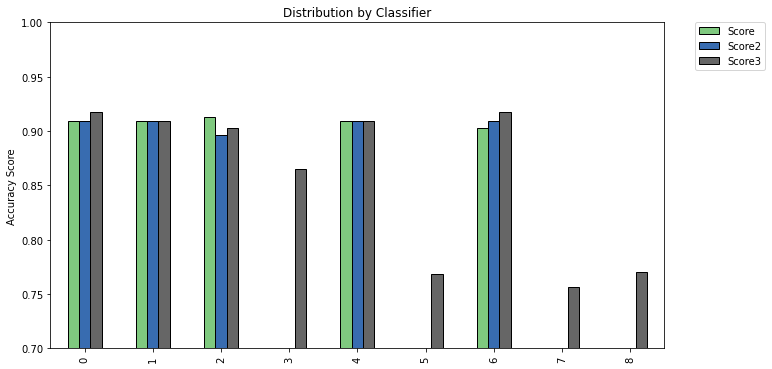

In [ ]:
score.plot(kind='bar', ylim=(0.7,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

This time everyone are doing a little bit worse, except for LinearRegression and RandomForest. But the winner is still MultinominalNaiveBayes.

### Voting classifier

We are using ensemble algorithms here, but what about ensemble of ensembles? Will it beat NB?

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
eclf = VotingClassifier(estimators=[('BgC', bc), ('ETC', etc), ('RF', rfc), ('Ada', abc)], voting='soft')

In [ ]:
eclf.fit(features_train,labels_train)

VotingClassifier(estimators=[('BgC',
                              BaggingClassifier(base_estimator=None,
                                                bootstrap=True,
                                                bootstrap_features=False,
                                                max_features=1.0,
                                                max_samples=1.0, n_estimators=9,
                                                n_jobs=None, oob_score=False,
                                                random_state=111, verbose=0,
                                                warm_start=False)),
                             ('ETC',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
         

In [ ]:
pred = eclf.predict(features_test)

In [ ]:
print(accuracy_score(labels_test,pred))



0.766612641815235


In [ ]:
#모델 저장
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
import pickle
from sklearn.externals import joblib


#GBoost 자리에 최적 모델쓰면돼요
with open('filename11.pkl', 'wb') as file:  
    pickle.dump(eclf, file)



In [ ]:
#데이터에 적용하기

In [ ]:
ap_data = pd.read_excel('AP open data_20201111.xlsx',sheet_name=0,usecols='A,B,C')
ap_data = ap_data[:]

ap_data.columns = ['ID','label','C1']
ap_data['C1'] = ap_data['C1'].apply(str)
ap_data['length'] = ap_data['C1'].apply(len)
ap_data.head()

,ID,label,C1,length
0,7,1,tet,3
1,83,1,해라,2
2,948,1,zxcvx,5
3,962,1,sdfsdg,6
4,1035,1,ttuyrt,6


In [ ]:
google_2020 = pd.read_excel('2020 google BAD sample(1-9).xlsm',sheet_name=0,usecols='A,B,C')
google_2020.columns = ['ID','label','C1']
google_2020['C1'] = google_2020['C1'].apply(str)
google_2020.drop_duplicates(subset=['C1'],inplace=True) # C1 열에서 중복인 내용이 있다면 중복 제거
google_2020['length'] = google_2020['C1'].apply(len)

google_x_test = google_2020['C1']
google_x_test = google_x_test.apply(text_process)
google_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1561 entries, 0 to 19644
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      1561 non-null   int64 
 1   label   1561 non-null   int64 
 2   C1      1561 non-null   object
 3   length  1561 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 61.0+ KB


In [ ]:
# pred = model.predict(features_test)
# print(accuracy_score(labels_test,pred.round()))

In [ ]:
google_x_test2 = google_x_test
google_x_features = vectorizer2.fit_transform(google_x_test2)
data = np.expand_dims(np.asarray(google_x_features), axis=0)
google_y_test = np.array(google_2020['label'])

In [ ]:
pred = eclf.predict(google_x_features.reshape(-1,1))

ValueError: ignored

In [ ]:
1. 분류별로 모델 생성
2. 통합 모델 